In [1]:
import sixdesk.da as da
import sixdesk.dist as dist
from sixdesk.da import davst_function, get_fitting_params_distribution, beamloss, get_da_from_fit_output

bl = beamloss()  # load the module to calculate the beam loss\
from matplotlib.colors import LogNorm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


In [2]:
def prepare_pcolormesh(df, x, y, z, weights=[1,1,1],offset=[0,0,0]):
    
    '''prepare the dataframe to obey the required shape in which no data is cut off
    see https://github.com/matplotlib/basemap/issues/107
    
    Usage: prepare_pcolormesh(data, 'chroma', 'ioct', 'DA',weights=[1,1,100])
    
    The passed dataframe "data" must contain the columns 'chroma', 'ioct', 'DA'. 
    The weighting option will weight x,y,z accoring to their positional value in the parsed array.
    Note that this algorithm does only work for equally spaced datasets.
    '''
    var1, var2 = x,y
    
    stepsize1 = np.diff(df[var1].unique()[-3:-1])[0]
    stepsize2 = np.diff(df[var2].unique()[-3:-1])[0]

    var1list  = np.append(np.unique(df[var1]), np.unique(df[var1])[-1]+stepsize1)
    var2list  = np.append(np.unique(df[var2]), np.unique(df[var2])[-1]+stepsize2)
    
    newdf = pd.DataFrame()
    for _v1 in var1list:
        for _v2 in var2list:
            if ((df[var1]==_v1) & (df[var2]==_v2)).any():
                newdf = newdf.append(df[(df[var1]==_v1) & (df[var2]==_v2)])
            else:
                # create array of variable length
                newrow = []
                for c in df.columns:
                    if c==var1:
                        newrow.append(_v1)
                    elif c==var2:
                        newrow.append(_v2)
                    else:
                        # append the mean value to the placeholder, to have physically realistic data
                        newrow.append(df[c].mean()) 

                # append to new dataframe
                newdf = newdf.append(pd.DataFrame([newrow],columns=df.columns),ignore_index=True)
                    
    x = newdf[x].values*weights[0]+offset[0]
    y = newdf[y].values*weights[1]+offset[1]
    z = newdf[z].values*weights[2]+offset[2]
    
    x=np.unique(x)
    y=np.unique(y)
    X,Y = np.meshgrid(y,x)
    Z   = z.reshape(len(x),len(y))
    return Y,X,Z

In [3]:
def emittance_growth_gauss(da):
    '''
    Emittance growth of a Gaussian distribution as a function of the dynamic aperture (DA).
    
    Parameters
    ----------
    da : dynamic aperture in terms of standard deviations of the transverse particle density distribution
    
    Examples
    ----------
    >>> growth = emittance_growth_gauss(12.)
    
    '''
    return (da**2*np.exp(-da**2/2))/(2*(1-np.exp(-da**2/2)))

In [4]:
def read_scan(name,
              var1,
              var1_range,
              var2,
              var2_range,
              fit=False,
              save=False,
              realizations=100,
              **kwargs):
    '''Read the extrapolated da for a set of simulations'''
    
    data = []
    
    scanpoints = len(var1_range) * len(var2_range)

    i=0
    for v1 in var1_range:
        for v2 in var2_range:
            i+=1
            dbname   = name.format(v1,v2) 
            print('[{0}/{1}] - {2}'.format(i,scanpoints,dbname), end='\r')
            try:
                b        = da.davst(dbname,2.5)
            except:
                data.append([v1,v2, 0, 0, 0, 0, 0, 0, 0, 0, 0]) 
                continue
            if fit:
                b.fit(save=save, **kwargs)
            b.get_extrapolated_da(minutes=30, save=save)
            b.get_extrapolated_da(minutes=30, realizations=realizations)
            exda = b.extrapolated_da['exda_1800_sec']
            exda = exda.clip(lower=0)
            loss = bl.get_loss_from_da_series(exda)
            data.append([v1,v2,exda.min(), exda.max(), exda.median(), exda.mean(), 
                            exda.std(), loss.min(), loss.max(), loss.mean(), loss.std()])

    data = pd.DataFrame(data,columns=[var1,var2,'exdamin','exdamax','exdamedian','exdamean',
                                                  'exdastd','lossmin','lossmax','lossmean','lossstd'])
    
    data = data.assign(eg_mean=emittance_growth_gauss(data['exdamean']))
    data = data.assign(eg_min=emittance_growth_gauss(data['exdamin']))
    data = data.assign(eg_max=emittance_growth_gauss(data['exdamax']))    

    return data

In [5]:
def scan_summary(data_b1, data_b2, scanvars, dalim=None, losslim=None, eglim=None, 
                 offset=[0,0,0], title1='', title2='',
                 var1_title='', var2_title=''):
    import matplotlib
    
    font = {'size'   : 15}
    plt.style.use('ggplot')

    matplotlib.rc('font', **font)
    
    if dalim is not None:
        da_lim1, da_lim2 = dalim
    else:
        min1,max1 = np.min(data_b1['exdamean']), np.max(data_b1['exdamean'])
        min2,max2 = np.min(data_b2['exdamean']), np.max(data_b2['exdamean'])
        da_lim1 = min(min1,min2)
        da_lim2 = max(max1,max2)
        print('da limits: {0}, {1}'.format(da_lim1, da_lim2))
        
        
    if losslim is not None:
        loss_lim1, loss_lim2 = losslim
    else:
        min1,max1 = np.min(data_b1['lossmean']), np.max(data_b1['lossmean'])
        min2,max2 = np.min(data_b2['lossmean']), np.max(data_b2['lossmean'])
        loss_lim1 = 100*min(min1,min2)
        loss_lim2 = 100*max(max1,max2)   
        
        
    if eglim is not None:
        egmin, egmax = eglim
    else:
        min1,max1 = np.min(data_b1['eg_mean']), np.max(data_b1['eg_mean'])
        min2,max2 = np.min(data_b2['eg_mean']), np.max(data_b2['eg_mean'])
        egmin = 100*min(min1,min2)
        egmax = 100*max(max1,max2)         
        
#     loss_lim1, loss_lim2 = losslim
    var1, var2 = scanvars

    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(321)            
    ax2 = fig.add_subplot(322)            
    ax3 = fig.add_subplot(323)            
    ax4 = fig.add_subplot(324)  
    ax5 = fig.add_subplot(325)            
    ax6 = fig.add_subplot(326)  

    X,Y,Z = prepare_pcolormesh(data_b1, var1, var2, 'exdamean', offset=offset)

    ax1.set_title(title1)
    ax1.set_ylabel(var2_title)

    im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
    fig.colorbar(im1,ax=ax1)

    X,Y,Z = prepare_pcolormesh(data_b1, var1, var2, 'lossmean',offset=offset,weights=[1,1,100])

    ax3.set_ylabel(var2_title)

    im3 = ax3.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                                             norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
    fig.colorbar(im3,ax=ax3)



    X,Y,Z = prepare_pcolormesh(data_b1, var1, var2, 'eg_mean',offset=offset,weights=[1,1,100])

    ax5.set_xlabel(var1_title)
    ax5.set_ylabel(var2_title)

    im5 = ax5.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=egmin, vmax=egmax,
                                             norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
    fig.colorbar(im5,ax=ax5)




    # # BEAM 2

    X,Y,Z = prepare_pcolormesh(data_b2, var1, var2, 'exdamean', offset=offset)

    ax2.set_title(title2)

    im1 = ax2.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=da_lim1, vmax=da_lim2)
    fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax2)


    X,Y,Z = prepare_pcolormesh(data_b2, var1, var2, 'lossmean',offset=offset,weights=[1,1,100])



    im4 = ax4.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=loss_lim1, vmax=loss_lim2,
                         norm=LogNorm(vmin=loss_lim1, vmax=loss_lim2))
    fig.colorbar(im4,label=r'Mean beam loss after 30min [$\%$]',ax=ax4)




    X,Y,Z = prepare_pcolormesh(data_b2, var1, var2, 'eg_mean',offset=offset,weights=[1,1,100])

    ax6.set_xlabel(var1_title)

    im6 = ax6.pcolormesh(X,Y,Z, cmap=cm.coolwarm, vmin=egmin, vmax=egmax,
                         norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
    fig.colorbar(im6,label=r'Mean $\Delta \epsilon/\epsilon$ after 30min [$\%$]',ax=ax6)



    for ax in fig.axes:
        ax.set_xticks(np.unique(data_b1[var1]))
        ax.set_yticks(np.unique(data_b1[var2]))

        labels = ax.get_xticklabels()
        plt.setp(labels, rotation=30)

        plt.tight_layout()
    plt.show()

# LHC at injection 2016

Define the range of the scan parameters

In [6]:
chromarange   = range(0,22,2)
octupolerange = range(0,44,4)

In [16]:
data_b1 = read_scan('/media/phermes/local/DA_studies/injection_2016/db/lhc_b1_inj_2016_qp_{0}_ioct_{1}.db',
                   'chroma', chromarange, 'ioct', octupolerange)

In [13]:
data_b2 = read_scan('/media/phermes/local/DA_studies/injection_2016/db/lhc_b2_inj_2016_qp_{0}_ioct_{1}.db',
                   'chroma', chromarange, 'ioct', octupolerange)

/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


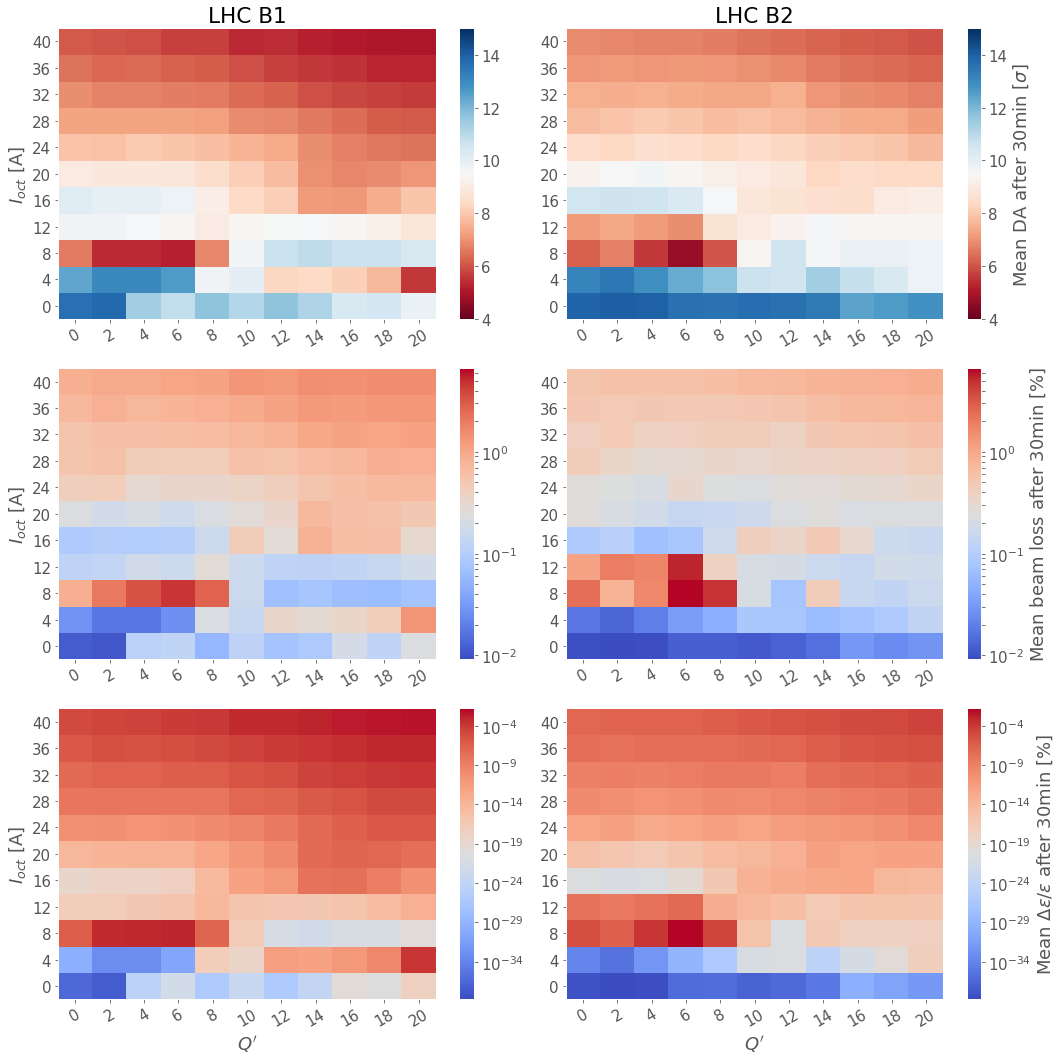

In [17]:
scan_summary(data_b1, data_b2, ['chroma','ioct'], dalim=[4,15], offset=[-1,-2,0], 
             title1='LHC B1', title2='LHC B2', var1_title=r"$Q'$", var2_title=r'$I_{oct}$ [A]')

# ATS 2017

In [7]:
data_b1 = read_scan('/media/phermes/local/DA_studies/ats2017/db/ats2017_b1_QP_{0}_IOCT_{1}.db',
                   'chroma', chromarange, 'ioct', octupolerange)

In [11]:
data_b2 = read_scan('/media/phermes/local/DA_studies/ats2017/db/ats2017_b2_QP_{0}_IOCT_{1}.db', 
                   'chroma', chromarange, 'ioct', octupolerange, fit=True, save=True)

da limits: 1.8678300452381178, 14.106739263016687


/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


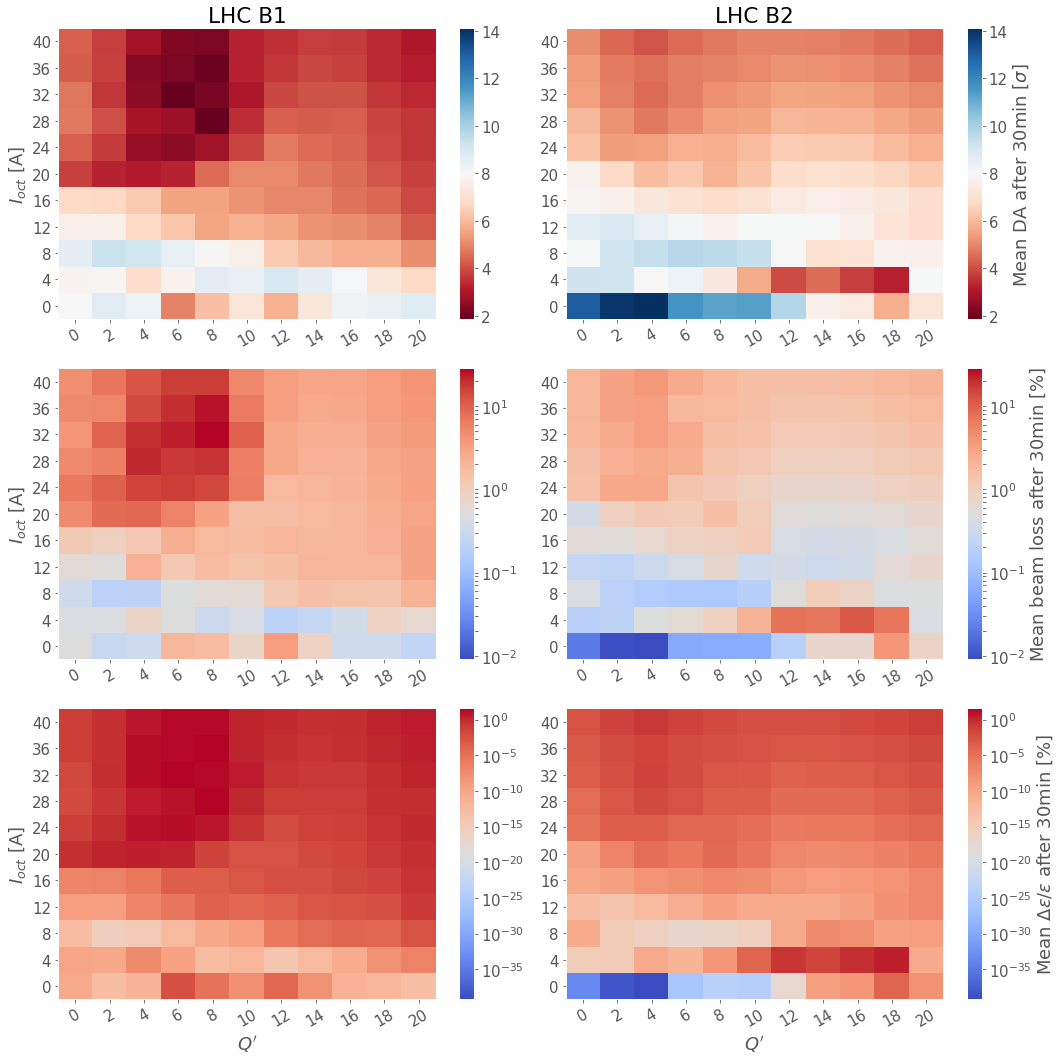

In [13]:
scan_summary(data_b1, data_b2, ['chroma','ioct'], offset=[-1,-2,0], 
             title1='LHC B1', title2='LHC B2', var1_title=r"$Q'$", var2_title=r'$I_{oct}$ [A]')

# HL-LHC V1.0

## Tune scan with $Q'=20$ and $I=+40\,$A

In [99]:
qxrange = np.arange(62.255,62.300,0.005)
qyrange = np.arange(60.280,60.330,0.005)

In [91]:
data_b1 = read_scan('/media/phermes/local/DA_studies/HL-LHC/db/hl10_injection_scan_{0:1.3f}_{1:1.3f}_B1.db',
                   'qx', qxrange, 'qy', qyrange)

In [92]:
data_b2 = read_scan('/media/phermes/local/DA_studies/HL-LHC/db/hl10_injection_scan_{0:1.3f}_{1:1.3f}_B4.db',
                   'qx', qxrange, 'qy', qyrange)

da limits: 0.516825692584305, 5.504400899630474


/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


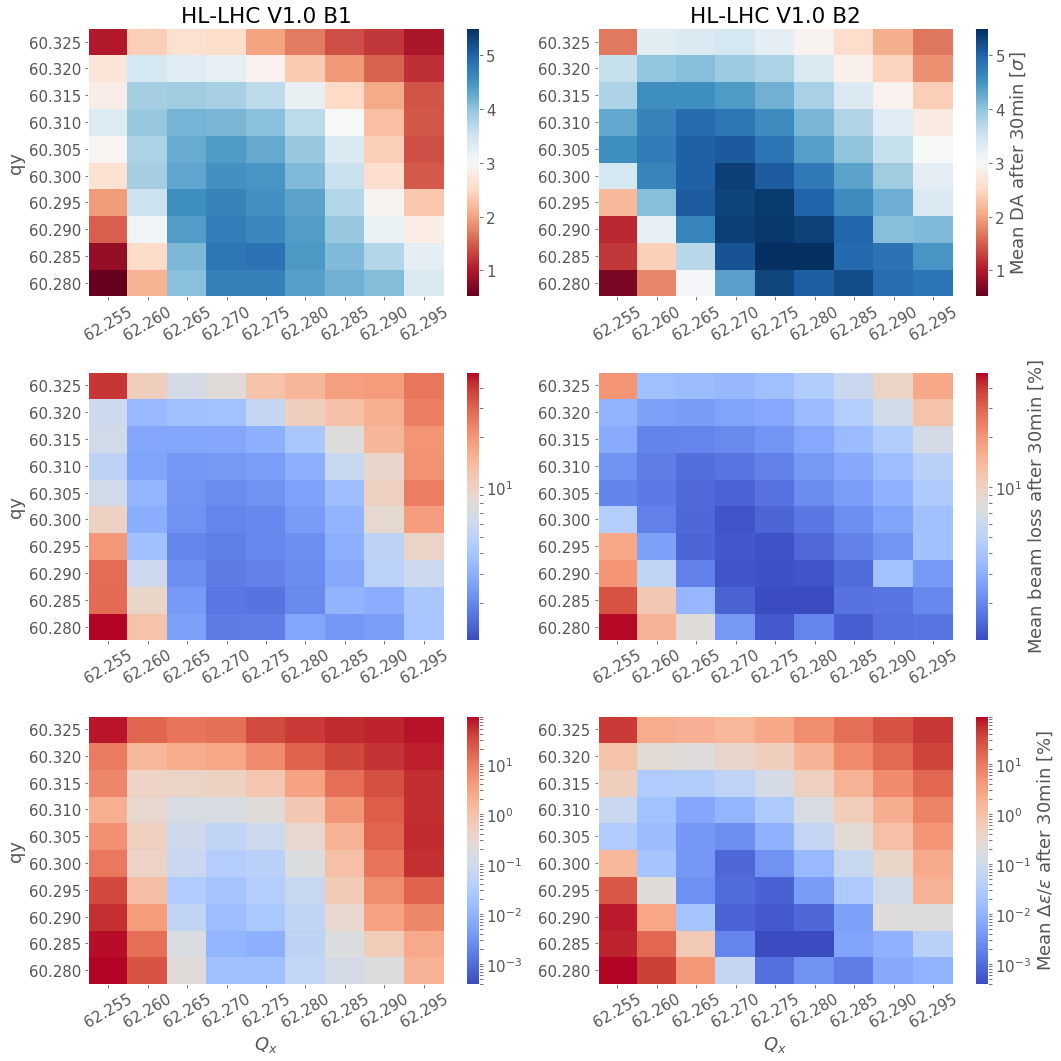

In [98]:
scan_summary(data_b1, data_b2, ['qx','qy'], offset=[-0.0025,-0.0025,0], 
             title1='HL-LHC V1.0 B1', title2='HL-LHC V1.0 B2', var1_title=r'$Q_x$', var2_title='qy')

## Tune scan with $Q'=20$ and $I=-40\,$A

In [100]:
data_b1 = read_scan('/media/phermes/local/DA_studies/HL-LHC/db/hl10_injection_scan_{0:1.3f}_{1:1.3f}_chrom_20_oct_-40_B1.db',
                   'qx', qxrange, 'qy', qyrange)

In [101]:
data_b2 = read_scan('/media/phermes/local/DA_studies/HL-LHC/db/hl10_injection_scan_{0:1.3f}_{1:1.3f}_chrom_20_oct_-40_B4.db',
                   'qx', qxrange, 'qy', qyrange)

da limits: 0.18069894616048293, 5.0906627874721


/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


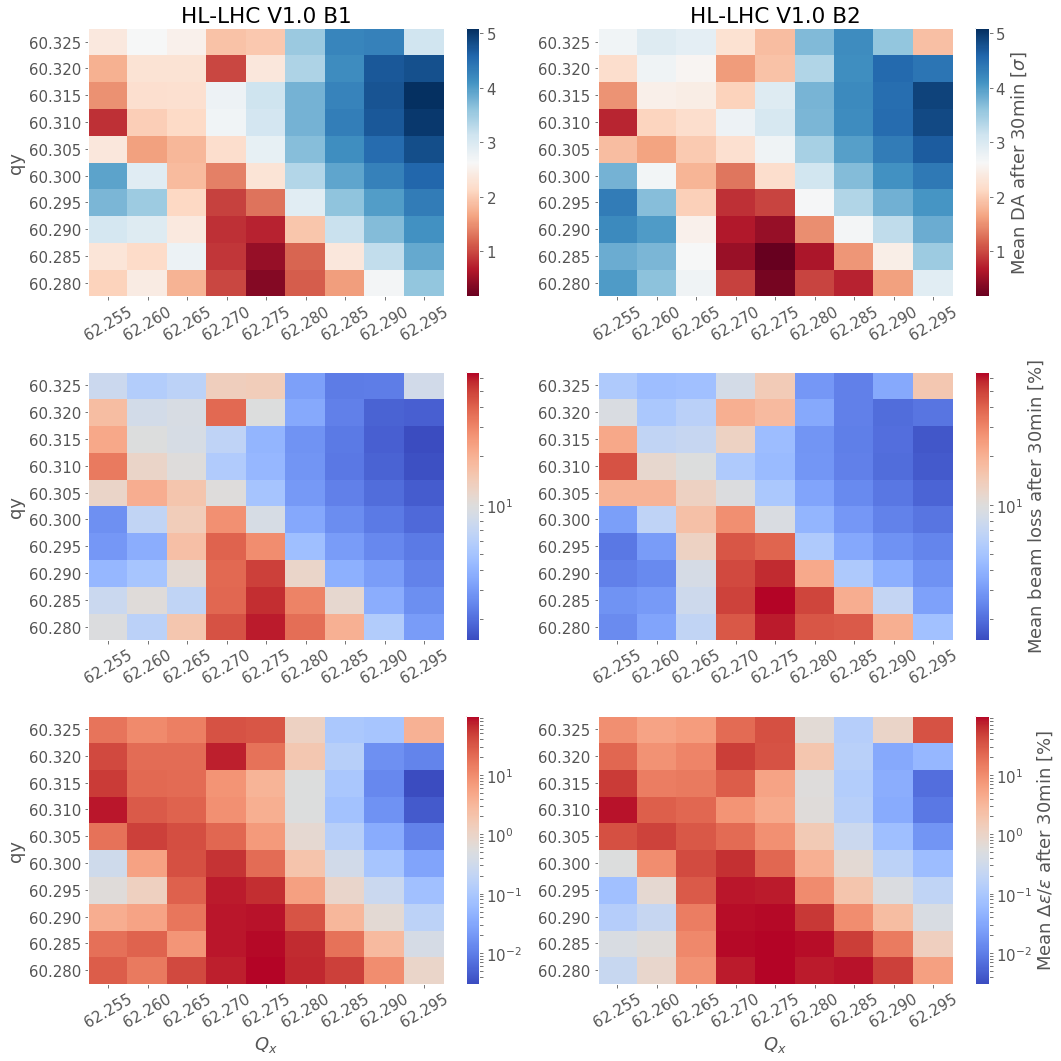

In [102]:
scan_summary(data_b1, data_b2, ['qx','qy'], offset=[-0.0025,-0.0025,0], 
             title1='HL-LHC V1.0 B1', title2='HL-LHC V1.0 B2', var1_title=r'$Q_x$', var2_title='qy')

## Tune scan with $Q'=3$ and $I=0\,$A

In [113]:
data_b1 = read_scan('/media/phermes/local/DA_studies/HL-LHC/db/hl10_injection_scan_{0:1.3f}_{1:1.3f}_chrom_3_oct_0_B1.db',
                   'qx', qxrange, 'qy', qyrange)

In [112]:
data_b2 = read_scan('/media/phermes/local/DA_studies/HL-LHC/db/hl10_injection_scan_{0:1.3f}_{1:1.3f}_chrom_3_oct_0_B4.db',
                   'qx', qxrange, 'qy', qyrange)

da limits: 5.634720583750584, 14.860794621880231


/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


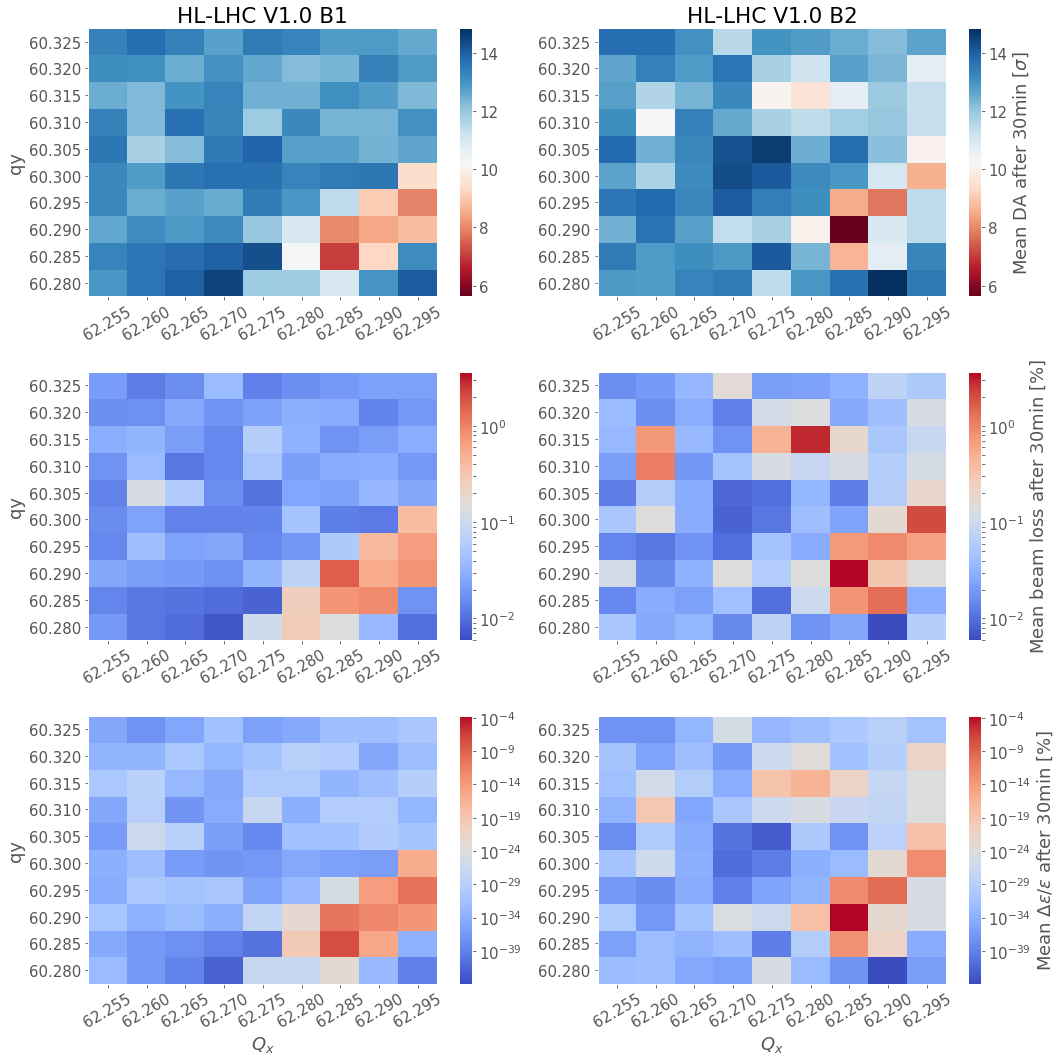

In [114]:
scan_summary(data_b1, data_b2, ['qx','qy'], offset=[-0.0025,-0.0025,0], 
             title1='HL-LHC V1.0 B1', title2='HL-LHC V1.0 B2', var1_title=r'$Q_x$', var2_title='qy')

# HL-LHC Scan over chromaticity and octupole current

In [108]:
chroma  = [0, 3, 5, 10, 15, 20]
ioct    = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
basedir = '/media/phermes/local/DA_studies/HL-LHC/db/'

In [109]:
data_b1 = read_scan(basedir+'hl10_injection_chrom_{0}_oct_{1}_B1.db',
                   'chroma', chroma, 'ioct', ioct)

In [110]:
data_b2 = read_scan(basedir+'hl10_injection_chrom_{0}_oct_{1}_B4.db',
                   'chroma', chroma, 'ioct', ioct)

da limits: 3.657780006130004, 14.598317824583432


/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


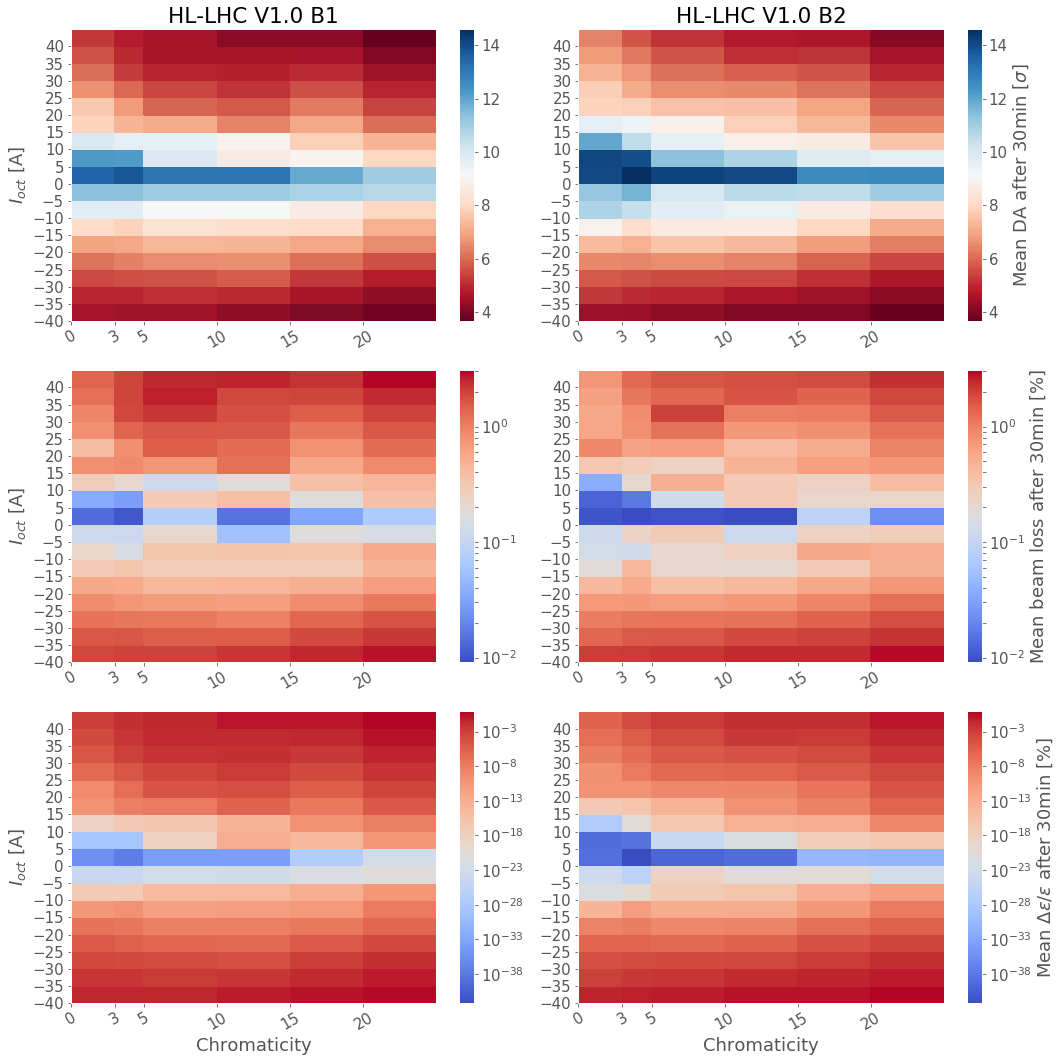

In [111]:
scan_summary(data_b1, data_b2, ['chroma','ioct'], offset=[-0.0025,-0.0025,0], 
             title1='HL-LHC V1.0 B1', title2='HL-LHC V1.0 B2', var1_title=r'Chromaticity', 
             var2_title=r'$I_{oct}$ [A]')

# Injection 2017 Tune Scan with and without BB

In [18]:
qx = np.arange(62.260, 62.282, 0.002)
qy = np.arange(60.275, 60.305, 0.002)

In [19]:
basedir = '/media/phermes/local/DA_studies/inj2017_bb/db_nobb/'

data_b1 = read_scan(basedir+'atsInj_{0:1.3f}_{1:1.3f}.db',
                   'qx', qx, 'qy', qy, fit=False, save=False, 
                    dacol='dawtrap', daerrcol='dawtraperr')

In [20]:
basedir = '/media/phermes/local/DA_studies/inj2017_bb/db_bb/'

data_bb = read_scan(basedir+'atsInj_{0:1.3f}_{1:1.3f}.db',
                   'qx', qx, 'qy', qy, fit=False, save=False, 
                    dacol='dawtrap', daerrcol='dawtraperr')

62.274 	60.281 is corrupted. We have to skip this simulation

In [31]:
data_bb.loc[115,('lossmean')] = np.nan

da limits: 0.0, 5.024571752486347


/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


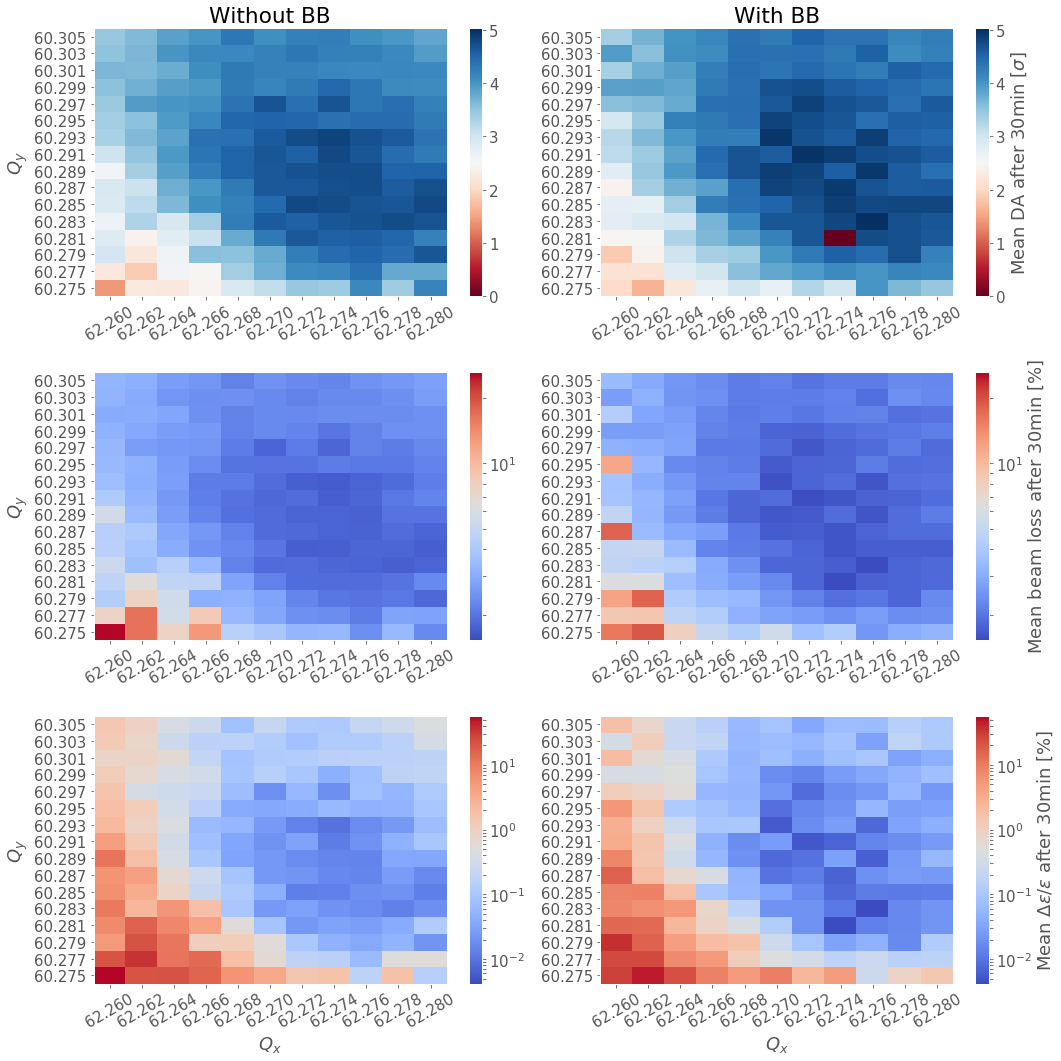

In [33]:
scan_summary(data_b1, data_bb, ['qx','qy'], offset=[-0.001,-0.001,0], 
             title1='Without BB', title2='With BB', var1_title=r'$Q_x$', 
             var2_title=r'$Q_y$')

By how much is the loss with BB larger than without?

In [48]:
lossbb = (data_bb['lossmean'] - data_b1['lossmean']).dropna()

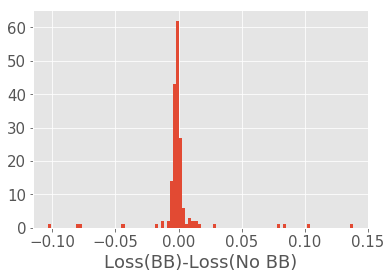

In [55]:
plt.hist(lossbb,bins=100)
plt.xlabel("Loss(BB)-Loss(No BB)")
plt.show()

In [50]:
lossbb.describe()

count    175.000000
mean      -0.000027
std        0.020260
min       -0.103079
25%       -0.002815
50%       -0.001253
75%        0.000671
max        0.138066
Name: lossmean, dtype: float64

In [52]:
dabb = (data_bb['exdamean'] - data_b1['exedamean']).dropna()

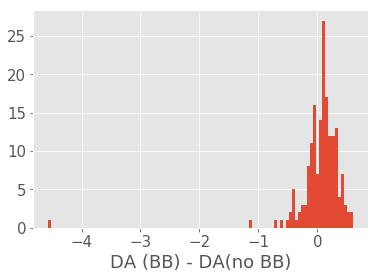

In [56]:
plt.hist(dabb,bins=100)
plt.xlabel("DA (BB) - DA(no BB)")
plt.show()

In [54]:
dabb.describe()

count    176.000000
mean       0.052101
std        0.428657
min       -4.562239
25%       -0.059197
50%        0.117541
75%        0.232973
max        0.601555
Name: exdamean, dtype: float64